Diagnostics in MOM6 can be saved in float or in double precision. This notebook is for testing if it is better to save data in double precision for vorticity budgets or not. 1/4 deg channel model simulation is used for this purpose.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [2]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Test_Precision/"

ds_p1 = xr.open_dataset(ppdir + "ocean_monthly_p1.nc")
ds_p2 = xr.open_dataset(ppdir + "ocean_monthly_p2.nc")

ds_grid = xr.open_dataset(ppdir + "grid.nc")

ds_p1 = xr.merge([ds_p1, ds_grid]) 
ds_p2 = xr.merge([ds_p2, ds_grid])

print(ds_p1, ds_p2)

<xarray.Dataset>
Dimensions:           (Time: 1, nv: 2, time: 2, xh: 320, xq: 320, yh: 272, yq: 272)
Coordinates:
  * xq                (xq) float64 0.25 0.5 0.75 1.0 ... 79.25 79.5 79.75 80.0
  * yh                (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * time              (time) object 0126-01-01 12:00:00 0126-01-02 12:00:00
  * nv                (nv) float64 1.0 2.0
  * xh                (xh) float64 0.125 0.375 0.625 0.875 ... 79.38 79.62 79.88
  * yq                (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
  * Time              (Time) object 0001-01-01 00:00:00
Data variables:
    hf_dudt_2d        (time, yh, xq) float64 ...
    hf_dvdt_2d        (time, yq, xh) float64 ...
    ubt_dt            (time, yh, xq) float64 ...
    vbt_dt            (time, yq, xh) float64 ...
    hf_PFu_2d         (time, yh, xq) float64 ...
    hf_PFv_2d         (time, yq, xh) float64 ...
    hf_CAu_2d         (time, yh, xq) float64 ...
    hf_CAv_2d         (time, y

In [4]:
# Create grid in xgcma and interpolate data on u. v points

rho_0 = 1035.
ds_p1 = ds_p1.isel(time=0)

grid = Grid(ds_p1, coords={'X': {'center': 'xh', 'right': 'xq'},
                           'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds_p1['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds_p1['deptho'], 'Y',  boundary='fill')
depth_q = grid.interp(depth_v, 'X',  boundary='fill')

beta_u =  grid.diff(ds_p1['Coriolis'], 'Y',  boundary='fill') / ds_p1['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

In [4]:
# Compute beta x depth_integrated v

vmo_p1 = beta_v * ds_p1['vmo_2d'] / (rho_0 * ds_p1['dxCv']).load()
vmo_p1 = grid.interp(vmo_p1, 'X',  boundary='fill')

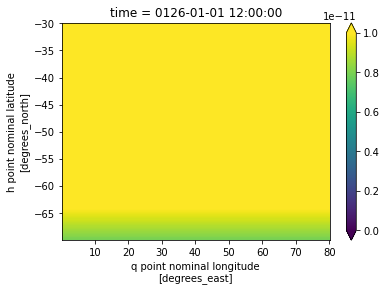

In [45]:
beta_u.plot(vmin=0, vmax=1e-11)

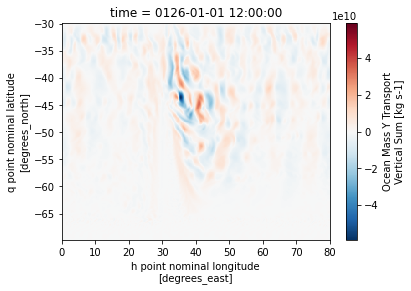

In [46]:
ds_p1['vmo_2d'].plot()

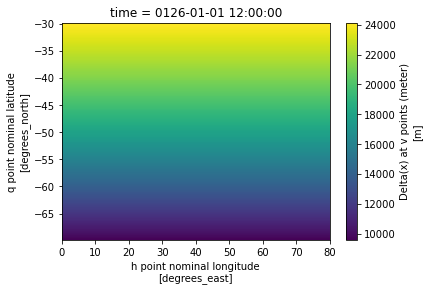

In [47]:
ds_p1['dxCv'].plot()

In [48]:
# Interpolate pbo, eta on u, v points

pbo_u = grid.interp(ds_p1['pbo'] - 1035. * 9.8 * ds_p1['deptho'], 'X',  boundary='fill')
pbo_v = grid.interp(ds_p1['pbo'] - 1035. * 9.8 * ds_p1['deptho'], 'Y',  boundary='fill')

zos_u = grid.interp(ds_p1['zos'], 'X',  boundary='fill')
zos_v = grid.interp(ds_p1['zos'], 'Y',  boundary='fill')

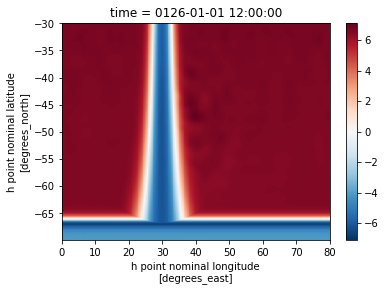

In [9]:
(ds_p1.pbo / (1035. *9.8) - ds_p1.deptho).plot()

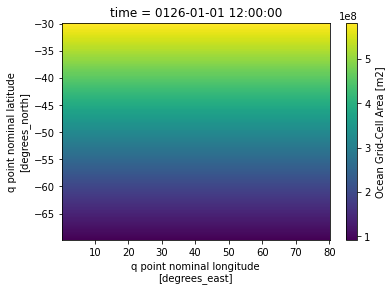

In [10]:
ds_p1['areacello_bu'].plot()

In [49]:
#hx = grid.diff(depth_v * ds_p1['dyCv'], 'X', boundary='fill') / ds_p1['areacello_bu']
#hy = grid.diff(depth_u * ds_p1['dxCu'], 'Y', boundary='fill') / ds_p1['areacello_bu']

hx = grid.diff(depth_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
hy = grid.diff(depth_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']


pbx = grid.diff(pbo_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
pby = grid.diff(pbo_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']

zos_x = grid.diff(zos_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
zos_y = grid.diff(zos_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']

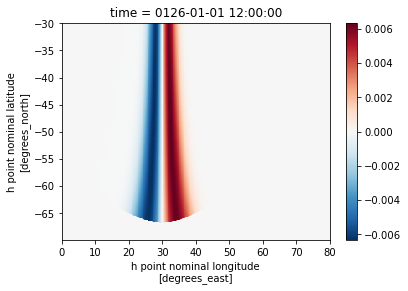

In [30]:
hx.plot(cmap='RdBu_r')

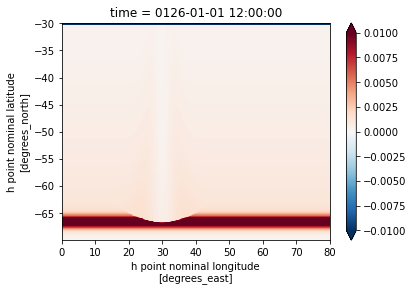

In [32]:
hy.plot(vmin=-0.01, vmax=0.01, cmap='RdBu_r')

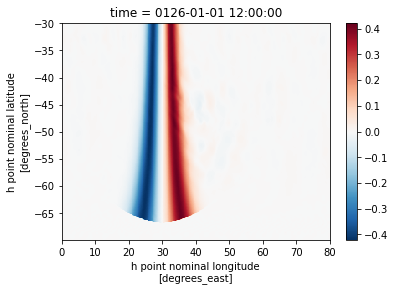

In [50]:
pbx.plot(cmap='RdBu_r')

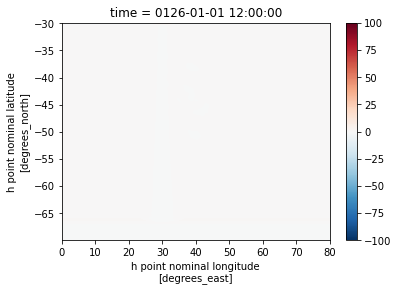

In [51]:
pby.plot(vmin=-100, vmax=100, cmap='RdBu_r')

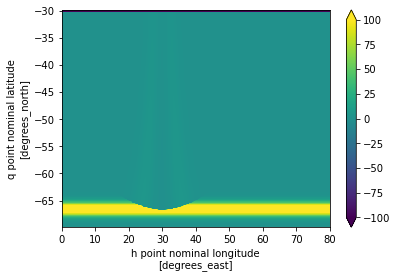

In [13]:
(grid.diff(ds_p1.deptho, 'Y', boundary='fill')).plot(vmin=-100, vmax=100)

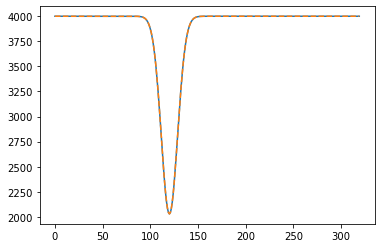

In [22]:
plt.plot(ds_p1.deptho.isel(yh=240))
plt.plot(depth_v.isel(yq=240),'--')

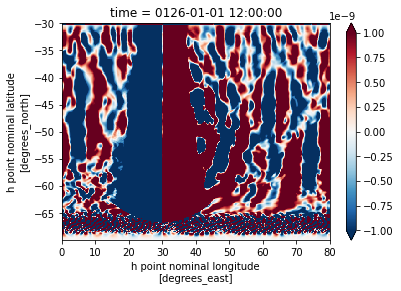

In [55]:
tmp1 = pbx * hy / rho_0
tmp2 = pby * hx / rho_0

BPT = ( pbx * hy - pby * hx ) / rho_0

#BPT_zos = ( zos_x * hy - zos_y * hx ) * 9.81

BPT.plot(vmin=-1e-9, vmax = 1e-9, cmap='RdBu_r')

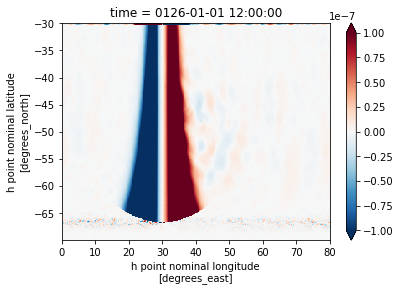

In [53]:
tmp1.plot(vmin=-1e-7, vmax = 1e-7, cmap='RdBu_r')

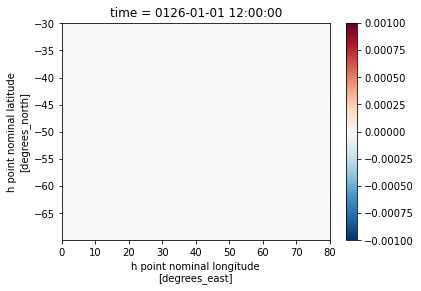

In [54]:
tmp2.plot(vmin=-1e-3, vmax = 1e-3, cmap='RdBu_r')

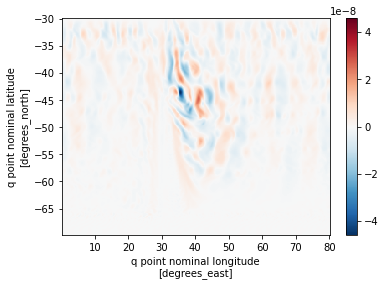

In [53]:
vmo_p1.plot()

In [15]:


pbo_u = grid.interp(ds_p1['pbo'], 'X',  boundary='fill')
pbo_v = grid.interp(ds_p1['pbo'], 'Y',  boundary='fill')

zos_u = grid.interp(ds_p1['zos'], 'X',  boundary='fill')
zos_v = grid.interp(ds_p1['zos'], 'Y',  boundary='fill')

BPT_p1 = (grid.diff(pbo_v * ds_p1['dyCv'], 'X',  boundary='fill') 
       * grid.diff(depth_u * ds_p1['dxCu'], 'Y',  boundary='fill')
      - grid.diff(pbo_u * ds_p1['dxCu'], 'Y',  boundary='fill') 
       * grid.diff(depth_v * ds_p1['dyCv'], 'X',  boundary='fill')) / (ds_p1['areacello_bu'] * ds_p1['areacello_bu'])
BPT_p1 = BPT_p1.load() / (rho_0)

BPT1_p1 = (grid.diff(zos_v * ds_p1['dyCv'], 'X',  boundary='fill') 
       * grid.diff(depth_u * ds_p1['dxCu'], 'Y',  boundary='fill')
      - grid.diff(zos_u * ds_p1['dxCu'], 'Y',  boundary='fill') 
       * grid.diff(depth_v * ds_p1['dyCv'], 'X',  boundary='fill')) / (ds_p1['areacello_bu'] * ds_p1['areacello_bu'])
BPT1_p1 = rho_0 * 9.81 * BPT1_p1.load() / (rho_0)

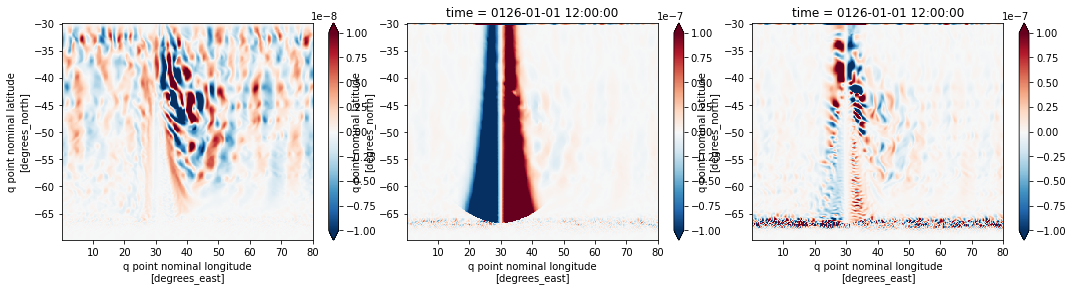

In [16]:
grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid1[0, 0])
vmo_p1.plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 1])
BPT_p1.plot(vmin=-1.e-7, vmax=1.e-7, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 2])
BPT1_p1.plot(vmin=-1.e-7, vmax=1.e-7, cmap='RdBu_r')

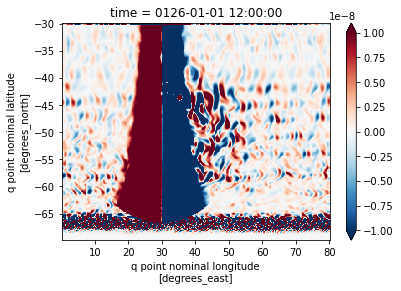

In [17]:
(BPT1_p1 - BPT_p1).plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

In [18]:
rho_0 = 1035.
ds_p2 = ds_p2.isel(time=0)

grid = Grid(ds_p2, coords={'X': {'center': 'xh', 'right': 'xq'},
                           'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds_p2['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds_p2['deptho'], 'Y',  boundary='fill')
depth_q = grid.interp(depth_v, 'X',  boundary='fill')

beta_u =  grid.diff(ds_p2['Coriolis'], 'Y',  boundary='fill') / ds_p2['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

In [19]:
vmo_p2 = beta_v * ds_p2['vmo_2d'] / (rho_0 * ds_p2['dxCv']).load()
vmo_p2 = grid.interp(vmo_p2, 'X',  boundary='fill')

pbo_u = grid.interp(ds_p2['pbo'], 'X',  boundary='fill')
pbo_v = grid.interp(ds_p2['pbo'], 'Y',  boundary='fill')

zos_u = grid.interp(ds_p2['zos'], 'X',  boundary='fill')
zos_v = grid.interp(ds_p2['zos'], 'Y',  boundary='fill')

BPT_p2 = (grid.diff((pbo_v)*ds_p2['dyCv'], 'X',  boundary='fill') 
       * grid.diff((depth_u + zos_u)* ds_p2['dxCu'], 'Y',  boundary='fill')
      - grid.diff((pbo_u)* ds_p2['dxCu'], 'Y',  boundary='fill') 
       * grid.diff((depth_v + zos_v)* ds_p2['dyCv'], 'X',  boundary='fill')) / (ds_p2['areacello_bu'] * ds_p2['areacello_bu'])
BPT_p2 = BPT_p2.load() / (rho_0)

BPT1_p2 = (grid.diff(zos_v * ds_p2['dyCv'], 'X',  boundary='fill') 
       * grid.diff(depth_u * ds_p2['dxCu'], 'Y',  boundary='fill')
      - grid.diff(zos_u * ds_p2['dxCu'], 'Y',  boundary='fill') 
       * grid.diff(depth_v * ds_p2['dyCv'], 'X',  boundary='fill')) / (ds_p2['areacello_bu'] * ds_p2['areacello_bu'])
BPT1_p2 = rho_0 * 9.81 * BPT1_p2.load() / (rho_0)

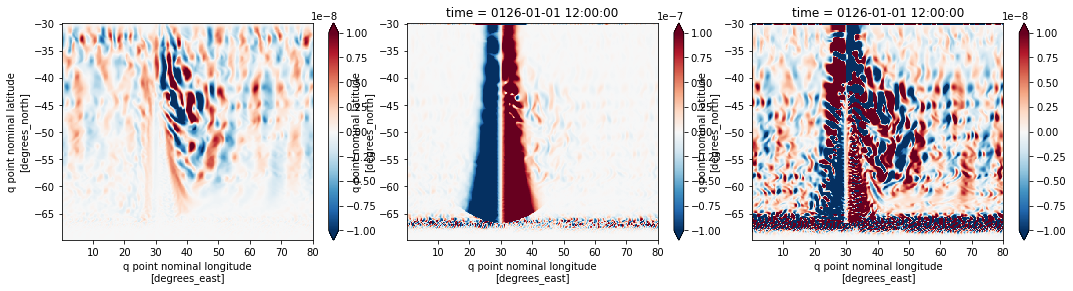

In [20]:
grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid1[0, 0])
vmo_p2.plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 1])
BPT_p2.plot(vmin=-1.e-7, vmax=1.e-7, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 2])
BPT1_p2.plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

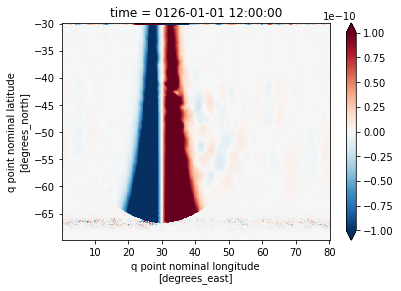

In [24]:
BPT1_p2.plot(vmin=-1.e-10, vmax=1.e-10, cmap='RdBu_r')

## Curl of depth-averaged momentum budget terms

In [7]:
# Take curl of depth-averaged momentum budget terms

ds = ds_p2.isel(time=0)

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

dzeta_dt = ( - grid.diff(ds['hf_dudt_2d'] * ds.dxCu, 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * ds.dyCv, 'X', boundary='fill') ) / ds.areacello_bu

zeta_CA = ( - grid.diff((ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_CAv_2d'] - ds['hf_gKEv_2d'] - ds['hf_rvxu_2d'])* ds.dyCv, 'X', boundary='fill'))/ ds.areacello_bu
zeta_CA = zeta_CA.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

zeta_K = ( - grid.diff(ds['hf_gKEu_2d'] * ds.dxCu, 'Y', boundary='fill')
           + grid.diff(ds['hf_gKEv_2d'] * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
zeta_K = zeta_K.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

zeta_rv = ( - grid.diff(ds['hf_rvxv_2d'] * ds.dxCu, 'Y', boundary='fill')
           + grid.diff(ds['hf_rvxu_2d'] * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
zeta_rv = zeta_rv.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

zeta_PF = ( - grid.diff((ds['hf_PFu_2d'] + ds['hf_u_BT_accel_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_PFv_2d'] + ds['hf_v_BT_accel_2d']) * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
zeta_PF = zeta_PF.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

zeta_diff = ( - grid.diff(ds['hf_diffu_2d']* ds.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['hf_diffv_2d']* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
zeta_diff = zeta_diff.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

zeta_visc = ( - grid.diff(ds['hf_du_dt_visc_2d']* ds.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['hf_dv_dt_visc_2d']* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
zeta_visc = zeta_visc.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

dzetabt_dt = ( - grid.diff(ds['ubt_dt']* ds.dxCu, 'Y', boundary='fill')
            + grid.diff(ds['vbt_dt']* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
dzetabt_dt = dzetabt_dt.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

curl_remap = dzeta_dt - zeta_CA - zeta_rv - zeta_K - zeta_PF - zeta_visc - zeta_diff

Text(0.5, 1.0, 'del x remapping term')

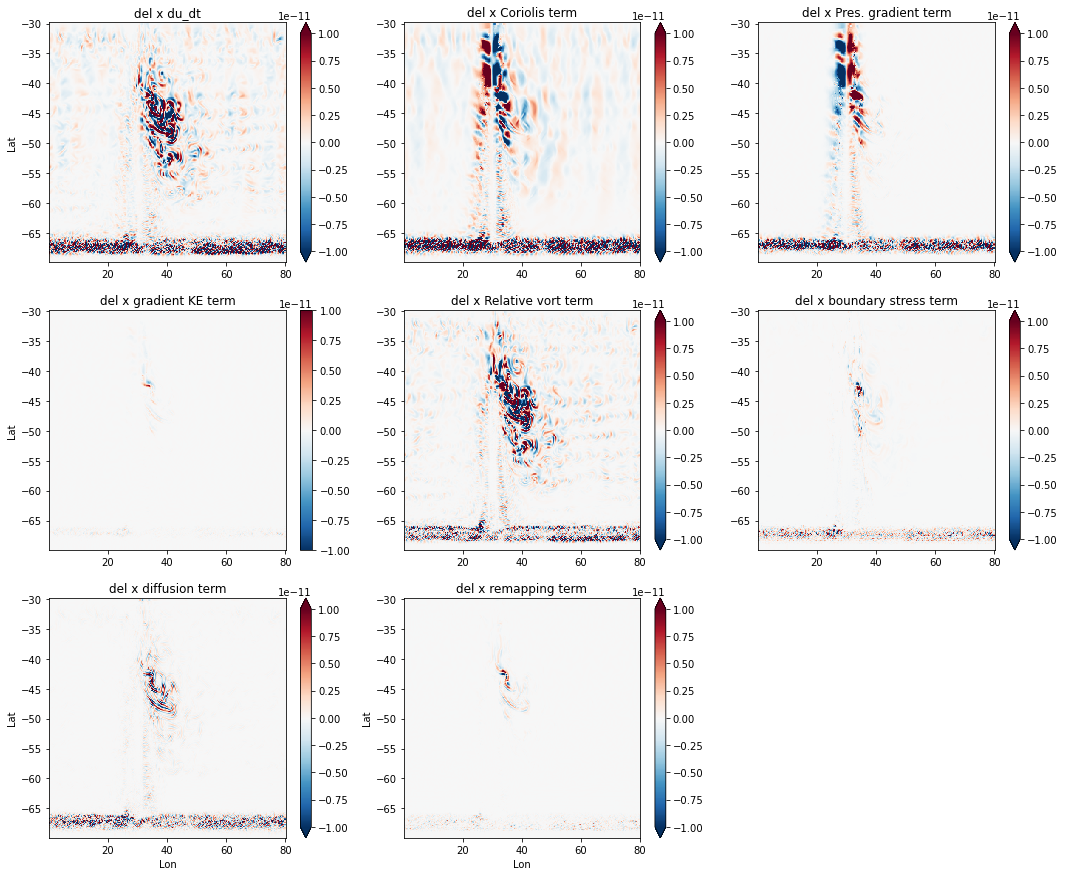

In [7]:
#grid1 = plt.GridSpec(3, 3, wspace=0.1, hspace=0.1)

fig = plt.figure(figsize=[18,15])

plt.subplot(3,3,1)
dzeta_dt.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel(" ") 
plt.ylabel('Lat')
plt.title('del x du_dt')

plt.subplot(3,3,2)
zeta_CA.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel(" ") 
plt.ylabel(" ")
plt.title('del x Coriolis term')

plt.subplot(3,3,3)
zeta_PF.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel(" ") 
plt.ylabel(" ")
plt.title('del x Pres. gradient term')

plt.subplot(3,3,4)
zeta_K.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel(" ") 
plt.ylabel('Lat')
plt.title('del x gradient KE term')

plt.subplot(3,3,5)
zeta_rv.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel(" ") 
plt.ylabel(" ")
plt.title('del x Relative vort term')

plt.subplot(3,3,6)
zeta_visc.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel(" ") 
plt.ylabel(" ")
plt.title('del x boundary stress term')

plt.subplot(3,3,7)
zeta_diff.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel("Lon") 
plt.ylabel('Lat')
plt.title('del x diffusion term')

plt.subplot(3,3,8)
curl_remap.plot(vmin = -1e-11, vmax= 1e-11, cmap='RdBu_r')
plt.xlabel("Lon") 
plt.ylabel('Lat')
plt.title('del x remapping term')

Text(0.5, 1.0, 'Sum')

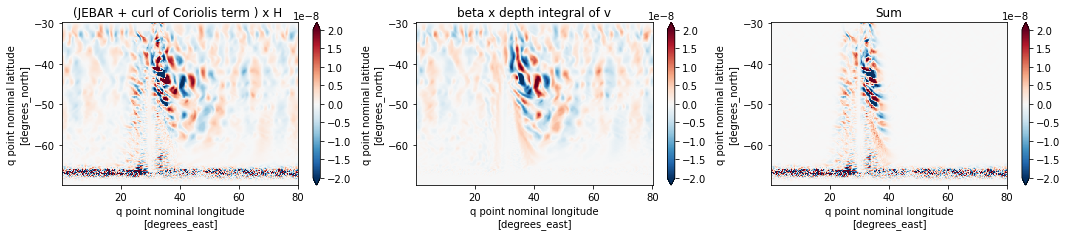

In [21]:
vmo_p1 = beta_v * ds['vmo_2d'] / (rho_0 * ds['dxCv'])
vmo_p1 = grid.interp(vmo_p1, 'X',  boundary='fill')

fig = plt.figure(figsize=[18,3])

plt.subplot(1,3,1)
((zeta_PF + zeta_CA)*depth_q).plot(vmin = -2e-8, vmax= 2e-8, cmap='RdBu_r')
plt.title('(JEBAR + curl of Coriolis term ) x H ')

plt.subplot(1,3,2)
vmo_p1.plot(vmin = -2e-8, vmax= 2e-8, cmap='RdBu_r')
plt.title('beta x depth integral of v')

plt.subplot(1,3,3)
((zeta_PF + zeta_CA)*depth_q + vmo_p1).plot(vmin = -2e-8, vmax= 2e-8, cmap='RdBu_r')
plt.title('Sum')

The summation of JEBAR and curl of Coriolis term are close to -ve of beta x depth integral of v. This is expected and comes out cleanly even in 1-day averaged fields.

### Computing BPT term 3 ways

1. Interpolate depth and bottom pressure on u, v points before. Then, use Stokes theorem to compute jacobian on q points.
2. Compute gradients of depth, pb first, and then interpolate derivatives to obtain jacobian on tracer points. We do not use Stokes theorem formulla in this.
3. Use second order central difference scheme to compute gradients and jacobian on tracer points. No interpolation required.

In [19]:
# Create grid in xgcma and interpolate data on u. v points

rho_0 = 1035.
ds_p1 = ds_p1.isel(time=0)

grid = Grid(ds_p1, coords={'X': {'center': 'xh', 'right': 'xq'},
                           'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds_p1['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds_p1['deptho'], 'Y',  boundary='fill')
depth_q = grid.interp(depth_v, 'X',  boundary='fill')

pbo_u = grid.interp(ds_p1['pbo'], 'X',  boundary='fill')
pbo_v = grid.interp(ds_p1['pbo'], 'Y',  boundary='fill')

beta_u =  grid.diff(ds_p1['Coriolis'], 'Y',  boundary='fill') / ds_p1['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

vmo_p1 = beta_v * ds_p1['vmo_2d'] / (rho_0 * ds_p1['dxCv']).load()
vmo_p1 = grid.interp(vmo_p1, 'X',  boundary='fill')

In [20]:
# Method 1

hx = grid.diff(depth_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
hy = grid.diff(depth_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']

pbx = grid.diff(pbo_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
pby = grid.diff(pbo_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']

BPT_1 = ( pbx * hy - pby * hx ) / rho_0

In [21]:
# Method 2

#hx = grid.diff(ds_p1['deptho'] * ds_p1['dyt'], 'X', boundary='fill') / ds_p1['areacello_cu']
#hy = grid.diff(ds_p1['deptho'] * ds_p1['dxt'], 'Y', boundary='fill') / ds_p1['areacello_cv']
hx = grid.diff(ds_p1['deptho'], 'X', boundary='fill') / ds_p1['dxCu']
hy = grid.diff(ds_p1['deptho'], 'Y', boundary='fill') / ds_p1['dyCv']

#pbx = grid.diff(ds_p1['pbo'] * ds_p1['dyt'], 'X', boundary='fill') / ds_p1['areacello_cu']
#pby = grid.diff(ds_p1['pbo'] * ds_p1['dxt'], 'Y', boundary='fill') / ds_p1['areacello_cv']

pbx = grid.diff(ds_p1['pbo'], 'X', boundary='fill') / ds_p1['dxCu']
pby = grid.diff(ds_p1['pbo'], 'Y', boundary='fill') / ds_p1['dyCv']


BPT_2 = (grid.interp(pbx, 'X', boundary='fill') * grid.interp(hy, 'Y', boundary='fill') -
       grid.interp(pby, 'Y', boundary='fill') * grid.interp(hx, 'X', boundary='fill')) / rho_0

In [9]:
# Method 3 

rho_0 = 1035.

ds = ds_p1.isel(time=0)

Nx = ds['dxt'].shape[1]
Ny = ds['dxt'].shape[0]

#ds_0 = ds

dx1 = 0.5 * (ds['dxt'].isel(xh=slice(0,Nx-2)).values + ds['dxt'].isel(xh=slice(1,Nx-1)).values)
dx2 = 0.5 * (ds['dxt'].isel(xh=slice(2,Nx)).values + ds['dxt'].isel(xh=slice(1,Nx-1)).values)

dy1 = 0.5 * (ds['dyt'].isel(yh=slice(0,Ny-2)).values + ds['dyt'].isel(yh=slice(1,Ny-1)).values)
dy2 = 0.5 * (ds['dyt'].isel(yh=slice(2,Ny)).values + ds['dyt'].isel(yh=slice(1,Ny-1)).values)

In [10]:
H = ds['deptho']
Pb = ds['pbo']

hx = (dx2 * dx2 * H.isel(xh=slice(2,Nx)).values - dx1 * dx1 * H.isel(xh=slice(0,Nx-2)).values
     + (dx1 * dx1 - dx2 * dx2) * H.isel(xh=slice(1,Nx-1)).values) / (dx1 * dx2 * (dx1 + dx2))

hy = (dy2 * dy2 * H.isel(yh=slice(2,Ny)).values - dy1 * dy1 * H.isel(yh=slice(0,Ny-2)).values
     + (dy1 * dy1 - dy2 * dy2) * H.isel(yh=slice(1,Ny-1)).values) / (dy1 * dy2 * (dy1 + dy2))

pbx = (dx2 * dx2 * Pb.isel(xh=slice(2,Nx)).values - dx1 * dx1 * Pb.isel(xh=slice(0,Nx-2)).values
     + (dx1 * dx1 - dx2 * dx2) * Pb.isel(xh=slice(1,Nx-1)).values) / (dx1 * dx2 * (dx1 + dx2))

pby = (dy2 * dy2 * Pb.isel(yh=slice(2,Ny)).values - dy1 * dy1 * Pb.isel(yh=slice(0,Ny-2)).values
     + (dy1 * dy1 - dy2 * dy2) * Pb.isel(yh=slice(1,Ny-1)).values) / (dy1 * dy2 * (dy1 + dy2))

BPT_FD = ( pbx[1:-1,:] * hy[:,1:-1] - pby[:,1:-1] * hx[1:-1,:] ) / rho_0

In [11]:
print(dx1.shape, dy1.shape, dx2.shape, dy2.shape, hx.shape, hy.shape, pbx.shape, pby.shape)

(272, 318) (270, 320) (272, 318) (270, 320) (272, 318) (270, 320) (272, 318) (270, 320)


Text(0.5, 1.0, '2nd order finite difference')

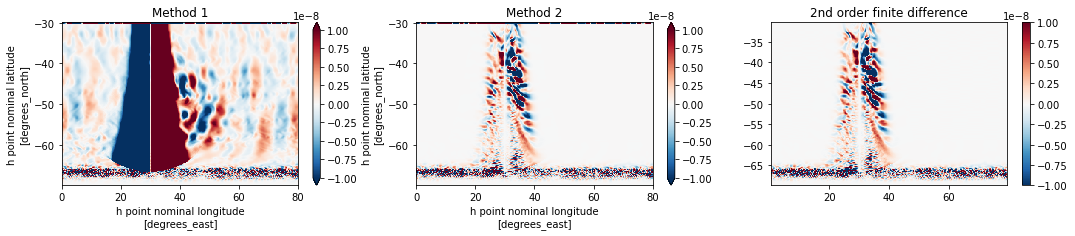

In [22]:
fig = plt.figure(figsize=[18,3])

plt.subplot(1,3,1)
(BPT_1).plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('Method 1')

plt.subplot(1,3,2)
(BPT_2).plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('Method 2')

plt.subplot(1,3,3)
#(vmo_p1).plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.pcolor(ds.xh.values[1:-1], ds.yh.values[1:-1], BPT_FD,cmap='RdBu_r')
plt.clim(-1e-8, 1e-8)
plt.colorbar()
plt.title('2nd order finite difference')

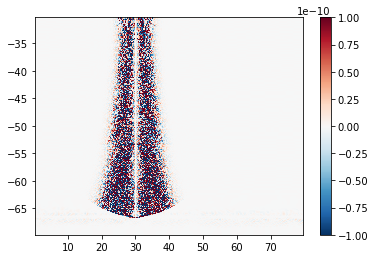

In [24]:
plt.pcolor(ds.xh.values[1:-1], ds.yh.values[1:-1], BPT_2.values[1:-1,1:-1] - BPT_FD,cmap='RdBu_r')
plt.clim(-1e-10, 1e-10)
plt.colorbar()

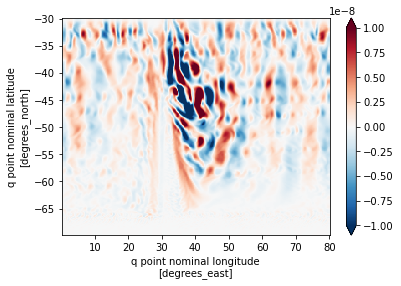

In [14]:
vmo_p1.plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')

### Use Stokes theorem and circulation to compute jacobian

$$BPT = \nabla \wedge \left(p_b \nabla H\right) = J(p_b,H)$$

In [16]:
# Compute BPT = del x (pb del H) = J(pb,H)

rho_0 = 1035.
ds = ds_p1.isel(time=0)

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds['deptho'], 'X', boundary='fill') 
depth_v = grid.interp(ds['deptho'], 'Y', boundary='fill')
depth_q = grid.interp(depth_v, 'X',  boundary='fill')

pbo_u = grid.interp(ds['pbo'], 'X',  boundary='fill')
pbo_v = grid.interp(ds['pbo'], 'Y',  boundary='fill')

hx = grid.diff(ds['deptho'], 'X', boundary='fill') / ds['dxCu']
hy = grid.diff(ds['deptho'], 'Y', boundary='fill') / ds['dyCv']

pbx = grid.diff(ds['pbo'], 'X', boundary='fill') / ds['dxCu']
pby = grid.diff(ds['pbo'], 'Y', boundary='fill') / ds['dyCv']

pb_hx = pbo_u * hx
pb_hy = pbo_v * hy

pbx_h = pbx * depth_u
pby_h = pby * depth_v

BPT1 = - ( - grid.diff(pbx_h * ds.dxCu, 'Y', boundary='fill')
            + grid.diff(pby_h * ds.dyCv, 'X', boundary='fill') ) / (ds.areacello_bu * rho_0)

#BPT = ( - grid.diff(pb_hx * ds.dxCu, 'Y', boundary='fill')
#            + grid.diff(pb_hy * ds.dyCv, 'X', boundary='fill') ) / (ds.areacello_bu * rho_0)

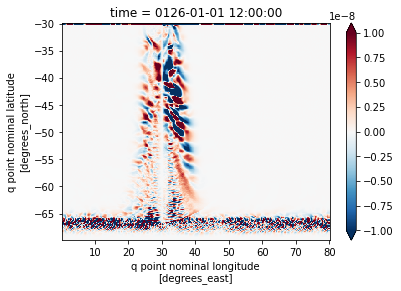

In [15]:
BPT.plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')

### Thickness-weighted interpolation

In [27]:
# Following "https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Metric-weighted-interpolation" 

metrics = {
    ('X',): ['dxCu', 'dxCv', 'dxt'], # X distances
    ('Y',): ['dyCv', 'dyCu', 'dyt'], # Y distances
    ('X', 'Y'): ['areacello', 'areacello_bu', 'areacello_cv', 'areacello_cu'] # Areas
}
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} },
            periodic=['X'], metrics=metrics)

depth_u = grid.interp(ds['deptho'], 'X', metric_weighted=['X','Y'], boundary='fill') 
depth_v = grid.interp(ds['deptho'], 'Y', metric_weighted=['X','Y'], boundary='fill')
depth_q = grid.interp(depth_v, 'X', metric_weighted=['X','Y'], boundary='fill')

pbo_u = grid.interp(ds['pbo'], 'X', metric_weighted=['X','Y'], boundary='fill')
pbo_v = grid.interp(ds['pbo'], 'Y', metric_weighted=['X','Y'], boundary='fill')

hx = grid.diff(ds['deptho'], 'X', metric_weighted=['X','Y'], boundary='fill') / ds['dxCu']
hy = grid.diff(ds['deptho'], 'Y', metric_weighted=['X','Y'], boundary='fill') / ds['dyCv']

pbx = grid.diff(ds['pbo'], 'X', metric_weighted=['X','Y'], boundary='fill') / ds['dxCu']
pby = grid.diff(ds['pbo'], 'Y', metric_weighted=['X','Y'], boundary='fill') / ds['dyCv']

pb_hx = pbo_u * hx
pb_hy = pbo_v * hy

pbx_h = pbx * depth_u
pby_h = pby * depth_v

BPT1 = - ( - grid.diff(pbx_h * ds.dxCu, 'Y', metric_weighted=['X','Y'], boundary='fill')
            + grid.diff(pby_h * ds.dyCv, 'X', metric_weighted=['X','Y'], boundary='fill') ) / (ds.areacello_bu * rho_0)

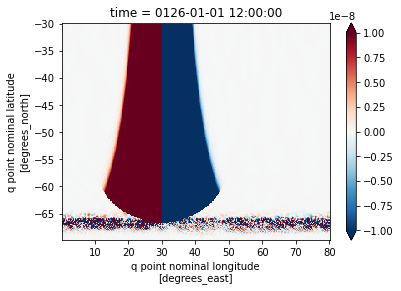

In [28]:
# from thickness-weighted interpolation
# This needs to be checked. There is an issue

BPT1.plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')

### Getting BPT with multiple methods and vorticity budget

In [3]:
ds = ds_p2.isel(time=0)

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

depth_u = grid.interp(ds['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds['deptho'], 'Y',  boundary='fill')

depth_q = grid.interp(depth_v, 'X',  boundary='fill')

beta_u =  grid.diff(ds['Coriolis'], 'Y',  boundary='fill') / ds['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

# beta * int_z (v) term

rho_0 = 1035.

vmo_bv = (beta_v * ds['vmo_2d'] / (rho_0 * ds['dxCv'])).load()
vmo_bv = grid.interp(vmo_bv, 'X',  boundary='fill')

vmo_bv = vmo_bv.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [4]:
# Method 1
# Compute BPT = - del x (H del pb) = J(pb,H) (with filered depth and pbo) 

BPT = xr.Dataset()

dims = ['yh', 'xh']

pbx = grid.diff(ds['pbo'], 'X', boundary='fill') / ds['dxCu']
pby = grid.diff(ds['pbo'], 'Y', boundary='fill') / ds['dyCv']

pbx_h = pbx * depth_u
pby_h = pby * depth_v

BPT_1 = - ( - grid.diff(pbx_h * ds.dxCu, 'Y', boundary='fill')
            + grid.diff(pby_h * ds.dyCv, 'X', boundary='fill') ) / (ds.areacello_bu * rho_0)

BPT['BPT_1'] = (BPT_1.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [5]:
# Method 2

BPT_2 = ( - grid.diff((ds['hf_PFu_2d'] + ds['hf_u_BT_accel_2d'])* depth_u * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_PFv_2d'] + ds['hf_v_BT_accel_2d']) * depth_v * ds.dyCv, 'X', boundary='fill') 
          ) / ds.areacello_bu

BPT['BPT_2'] = (BPT_2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [6]:
# Method 3

# Compute JEBAR term and curl of Coriolis term

Curl_Cor = ( - grid.diff((ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_CAv_2d'] - ds['hf_gKEv_2d'] - ds['hf_rvxu_2d'])* ds.dyCv, 'X', boundary='fill'))/ ds.areacello_bu
Curl_Cor = Curl_Cor.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

JEBAR = ( - grid.diff((ds['hf_PFu_2d'] + ds['hf_u_BT_accel_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_PFv_2d'] + ds['hf_v_BT_accel_2d']) * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
JEBAR = JEBAR.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Mass_Surf = (grid.interp(grid.interp(ds['wfo'], 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'] / (rho_0))
Mass_Surf = Mass_Surf.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT['BPT_32'] = ((depth_q * JEBAR + depth_q * Curl_Cor + vmo_bv + Mass_Surf).load()
                ).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

hx = grid.interp(grid.diff(ds.deptho, 'X', boundary='fill') / ds['dxCu'], 'Y', boundary='fill')
hy = grid.interp(grid.diff(ds.deptho, 'Y', boundary='fill') / ds['dyCv'], 'X', boundary='fill')

vg_hy = - grid.interp(ds['hf_PFu_2d'] + ds['hf_u_BT_accel_2d'], 'Y', boundary='fill') * hy
ug_hx = grid.interp(ds['hf_PFv_2d'] + ds['hf_v_BT_accel_2d'], 'X', boundary='fill') * hx

BPT['BPT_31'] = ((ug_hx + vg_hy + depth_q * JEBAR).load()
                ).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Text(0.5, 1.0, 'Method 32')

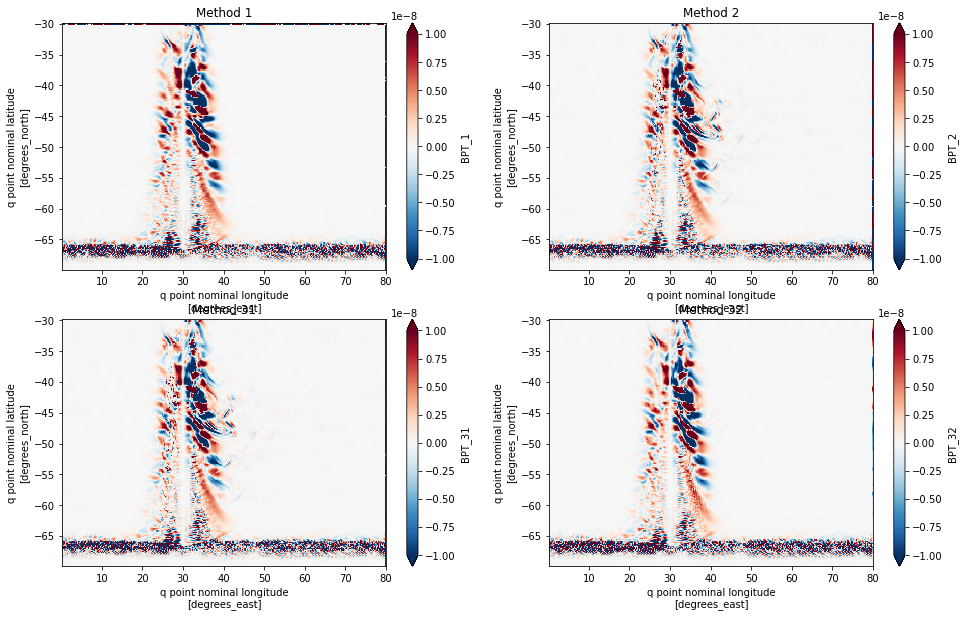

In [7]:
fig = plt.figure(figsize=[16,10])

plt.subplot(2,2,1)
BPT['BPT_1'].plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')
plt.title('Method 1')

plt.subplot(2,2,2)
BPT['BPT_2'].plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')
plt.title('Method 2')

plt.subplot(2,2,3)
BPT['BPT_31'].plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')
plt.title('Method 31')

plt.subplot(2,2,4)
BPT['BPT_32'].plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')
plt.title('Method 32')

In [8]:
# Rest of the terms in vorticity budget

Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * depth_u * ds['dxCu'], 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * depth_v * ds['dyCv'], 'X', boundary='fill') ) / ds.areacello_bu 
BPT['Curl_dudt'] = (Curl_dudt.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taus = ( - grid.diff((ds['taux'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff((ds['tauy']-ds['tauy_bot'])* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
Curl_taus = Curl_taus / (rho_0 )
BPT['Curl_taus'] = (Curl_taus.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
Curl_taub = Curl_taub / (rho_0 )
BPT['Curl_taub'] = (Curl_taub.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hrv = ( - grid.diff((ds['hf_rvxv_2d'] + ds['hf_gKEu_2d']) * depth_u * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_rvxu_2d'] + ds['hf_gKEv_2d']) * depth_v * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
BPT['Curl_NL'] = (Curl_Hrv.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hdiff = ( - grid.diff(ds['hf_diffu_2d'] * depth_u * ds.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['hf_diffv_2d']  * depth_v * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
BPT['Curl_Hdiff'] = (Curl_Hdiff.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT['vmo_bv'] = vmo_bv
BPT['Qm'] = - Mass_Surf

In [9]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.2)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

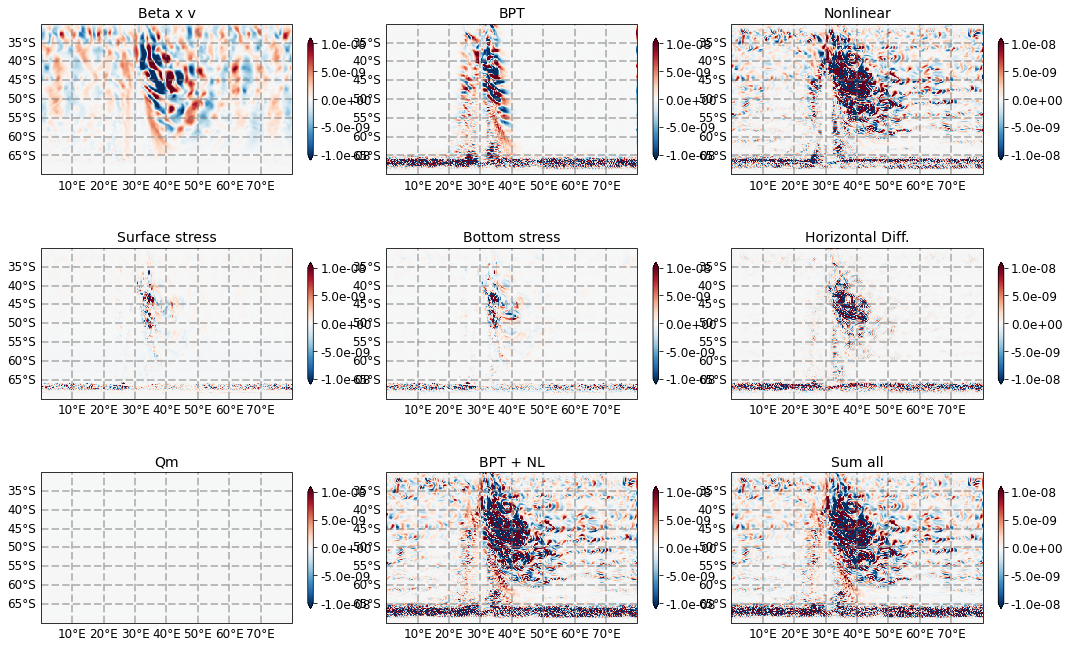

In [10]:
max_r = 1.e-8
lat_lon_ext = [0., 80., -70., -30.]

grid1 = plt.GridSpec(3, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,12])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Beta x v')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT_32'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['Curl_NL'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Nonlinear')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Surface stress')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Bottom stress')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['Curl_Hdiff'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Horizontal Diff.')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['Qm'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Qm')

ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT_32'] + BPT['Curl_NL'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT + NL')

tmp = BPT['BPT_32'] + BPT['Curl_NL'] + BPT['Qm'] + BPT['Curl_Hdiff'] + BPT['Curl_taub'] + BPT['Curl_taus']
ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Sum all')

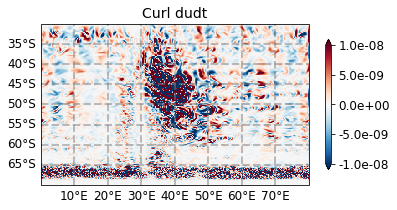

In [11]:
grid1 = plt.GridSpec(1, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[6,4])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['Curl_dudt'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Curl dudt')

In [12]:
#ds.close()
ds_p1.close()
ds_p2.close()